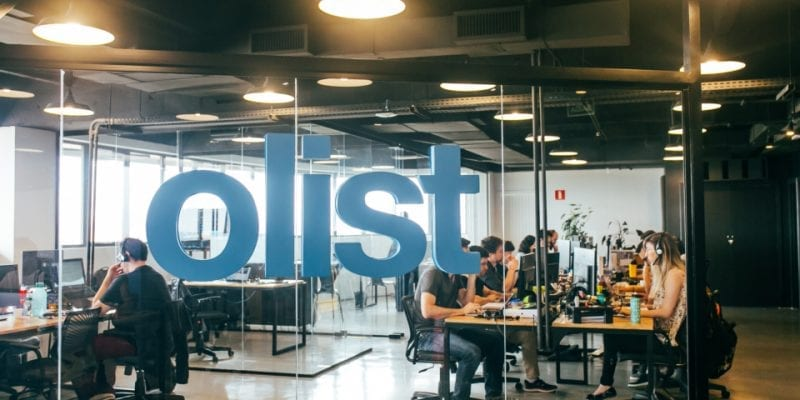

# Brazilian E-Commerce Olist Customers Segmentation

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

In [1]:
# ! usr/bin/env python 3
# coding: utf-8

# Importing librairies

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from IPython.display import HTML
import numpy as np               # numerical data processing
import pandas as pd              # numerical tables & time series
import scipy as sp
# numerical integration, interpolation, optimization and statistics
import scipy.stats as st         # statistical functions
import seaborn as sns            # statistical data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# static, animated, and interactive visualizations in Python
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_samples, silhouette_score, \
                            adjusted_rand_score
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, \
                                InterclusterDistance
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Individuals factor map - PCA (on F{} & F{})".format(d1+1, d2+1))
            plt.show(block=False)

1:80: E501 line too long (112 > 79 characters)
2:11: E231 missing whitespace after ','
4:1: W293 blank line contains whitespace
5:42: W291 trailing whitespace
6:40: E231 missing whitespace after ','
7:1: W293 blank line contains whitespace
10:80: E501 line too long (80 > 79 characters)
15:80: E501 line too long (111 > 79 characters)
20:22: E231 missing whitespace after ','
20:25: E231 missing whitespace after ','
20:55: E231 missing whitespace after ','
20:59: E231 missing whitespace after ','
22:31: E127 continuation line over-indented for visual indent
22:57: E231 missing whitespace after ','
22:70: W291 trailing whitespace
23:1: W293 blank line contains whitespace
25:56: E231 missing whitespace after ','
26:32: E231 missing whitespace after ','
27:32: E231 missing whitespace after ','
28:1: W293 blank line contains whitespace
34:80: E501 line too long (96 > 79 characters)
34:92: E231 missing whitespace after ','
35:80: E501 line too long (96 > 79 characters)
35:92: E231 missing whit

In [3]:
# Transforming our input files.csv from the cleaning phase to dataframe

rfm_norm = pd.read_csv("rfm_norm.csv")
rfm_norm = rfm_norm.drop(['Unnamed: 0'], axis=1)
df_rfm = pd.read_csv('rfm.csv')

## 1. INPUT FILES OVERVIEW 

In [4]:
df_rfm

customer_id  recency  monetary  frequency
0      00012a2ce6f8dcda20d059ce98491703      287    114.74          1
1      000161a058600d5901f007fab4c27140      409     67.41          1
2      0001fd6190edaaf884bcaf3d49edf079      547    195.42          1
3      0002414f95344307404f0ace7a26f1d5      378    179.35          1
4      000379cdec625522490c315e70c7a9fb      149    107.01          1
...                                 ...      ...       ...        ...
95827  fffcb937e9dd47a13f05ecb8290f4d3e      165     91.91          1
95828  fffecc9f79fd8c764f843e9951b11341      152     81.36          1
95829  fffeda5b6d849fbd39689bb92087f431       99     63.13          1
95830  ffff42319e9b2d713724ae527742af25       76    214.13          1
95831  ffffa3172527f765de70084a7e53aae8      361     45.50          2

[95832 rows x 4 columns]

In [5]:
rfm_norm

recency  frequency  monetary
0      0.314200  -0.208641 -0.268701
1      1.112309  -0.425418 -0.268701
2      2.015089   0.160884 -0.268701
3      0.909511   0.087281 -0.268701
4     -0.588579  -0.244045 -0.268701
...         ...        ...       ...
95827 -0.483909  -0.313205 -0.268701
95828 -0.568953  -0.361525 -0.268701
95829 -0.915673  -0.445021 -0.268701
95830 -1.066136   0.246578 -0.268701
95831  0.798299  -0.525768  1.547122

[95832 rows x 3 columns]

### Distribution of variables

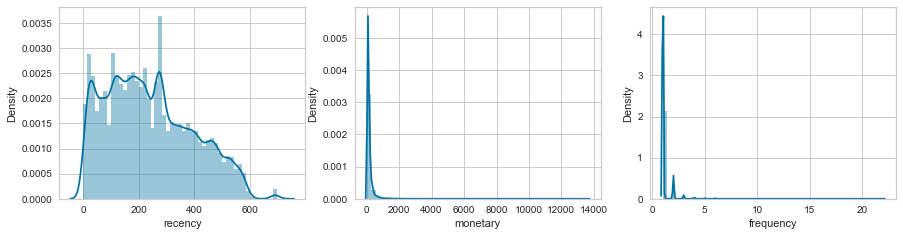

In [6]:
fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(331)
sns.distplot(df_rfm['recency'], ax=ax)

ax = fig.add_subplot(332)
sns.distplot(df_rfm['monetary'], ax=ax)

ax = fig.add_subplot(333)
sns.distplot(df_rfm['frequency'], ax=ax)
plt.show()

### Transformation of our key variables into log scale

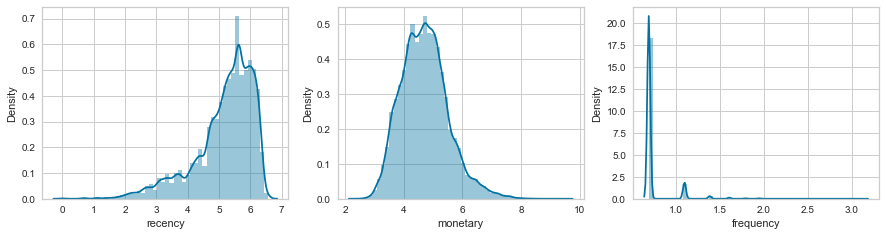

In [7]:
fig = plt.figure(figsize=(15, 12))
df_rfm = df_rfm.set_index('customer_id')
df_rfm_log = np.log1p(df_rfm)
ax = fig.add_subplot(331)
sns.distplot(df_rfm_log['recency'], ax=ax)

ax = fig.add_subplot(332)
sns.distplot(df_rfm_log['monetary'], ax=ax)

ax = fig.add_subplot(333)
sns.distplot(df_rfm_log['frequency'], ax=ax)
plt.show()

In [8]:
df_rfm_log.describe()

recency      monetary     frequency
count  95832.000000  95832.000000  95832.000000
mean       5.167122      4.705647      0.746008
std        0.946227      0.800167      0.170305
min        0.000000      2.359910      0.693147
25%        4.753590      4.143293      0.693147
50%        5.398163      4.667018      0.693147
75%        5.857933      5.181109      0.693147
max        6.570883      9.522599      3.135494

In [9]:
scaler = QuantileTransformer()
scaler.fit(df_rfm_log)
df_rfm_log.describe()

recency      monetary     frequency
count  95832.000000  95832.000000  95832.000000
mean       5.167122      4.705647      0.746008
std        0.946227      0.800167      0.170305
min        0.000000      2.359910      0.693147
25%        4.753590      4.143293      0.693147
50%        5.398163      4.667018      0.693147
75%        5.857933      5.181109      0.693147
max        6.570883      9.522599      3.135494

In [10]:
rfm_log_scaled = scaler.transform(df_rfm_log)
rfm_log_scaled = pd.DataFrame(rfm_log_scaled, columns=df_rfm_log.columns)
rfm_log_scaled.describe()
# RFM_Table_scaled

recency      monetary     frequency
count  95832.000000  95832.000000  95832.000000
mean       0.499981      0.500001      0.098704
std        0.288700      0.288679      0.289587
min        0.000000      0.000000      0.000000
25%        0.249750      0.249875      0.000000
50%        0.500000      0.499562      0.000000
75%        0.750250      0.749958      0.000000
max        1.000000      1.000000      1.000000

### K Means

In [11]:
from sklearn import cluster, metrics

### Elbow Method

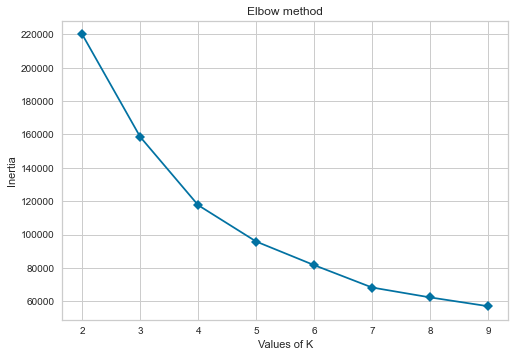

In [12]:
ssd = []
clusters_range = range(2, 10, 1)
for num_clusters in clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_norm)
    ssd.append(kmeans.inertia_)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.plot(range(2, 10), ssd, marker='D')
plt.show()

In [13]:
kl = KneeLocator(range(2, 10), ssd, curve="convex", direction="decreasing")
kl.elbow

4

### LOG SCALE

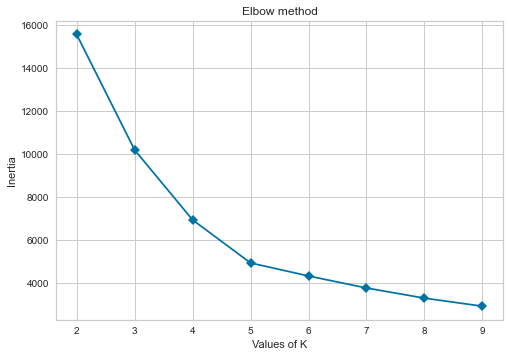

In [14]:
ssd = []
clusters_range = range(2, 10, 1)
for num_clusters in clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_log_scaled)
    ssd.append(kmeans.inertia_)
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.plot(range(2, 10), ssd, marker='D')
plt.show()

In [15]:
kl = KneeLocator(range(2, 10), ssd, curve="convex", direction="decreasing")
kl.elbow

5

### 2nd option

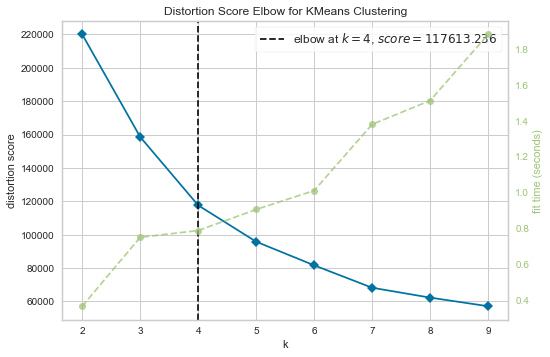

3:42: E231 missing whitespace after ','


In [16]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(rfm_norm)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

### Silhouette profile

In [17]:
k_means_silhouette = []

for n_clusters in clusters_range:    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = cluster.KMeans(n_clusters=n_clusters, max_iter=50)
    kmeans.fit(rfm_norm)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_norm, cluster_labels)
    k_means_silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,2))

For n_clusters = 2 The average silhouette_score is : 0.38
For n_clusters = 3 The average silhouette_score is : 0.42
For n_clusters = 4 The average silhouette_score is : 0.43
For n_clusters = 5 The average silhouette_score is : 0.47
For n_clusters = 6 The average silhouette_score is : 0.4
For n_clusters = 7 The average silhouette_score is : 0.42
For n_clusters = 8 The average silhouette_score is : 0.42


3:34: W291 trailing whitespace
12:68: E231 missing whitespace after ','


For n_clusters = 9 The average silhouette_score is : 0.42


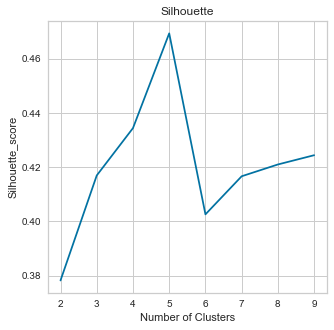

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(clusters_range, k_means_silhouette)
plt.title('Silhouette')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette_score')  # within cluster sum of squares
plt.show()

### LOG SCALE

In [19]:
ssd = []

for n_clusters in clusters_range:    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = cluster.KMeans(n_clusters=n_clusters, max_iter=50)
    kmeans.fit(rfm_log_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_log_scaled, cluster_labels)
    ssd.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,2))

For n_clusters = 2 The average silhouette_score is : 0.3
For n_clusters = 3 The average silhouette_score is : 0.38
For n_clusters = 4 The average silhouette_score is : 0.4
For n_clusters = 5 The average silhouette_score is : 0.42
For n_clusters = 6 The average silhouette_score is : 0.41
For n_clusters = 7 The average silhouette_score is : 0.38
For n_clusters = 8 The average silhouette_score is : 0.38


3:34: W291 trailing whitespace
12:68: E231 missing whitespace after ','


For n_clusters = 9 The average silhouette_score is : 0.37


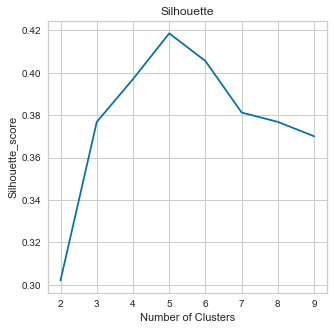

In [20]:
plt.figure(figsize=(5, 5))
plt.plot(clusters_range, ssd)
plt.title('Silhouette')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette_score')  # within cluster sum of squares
plt.show()

### 2nd Option: Calinski-Harabasz

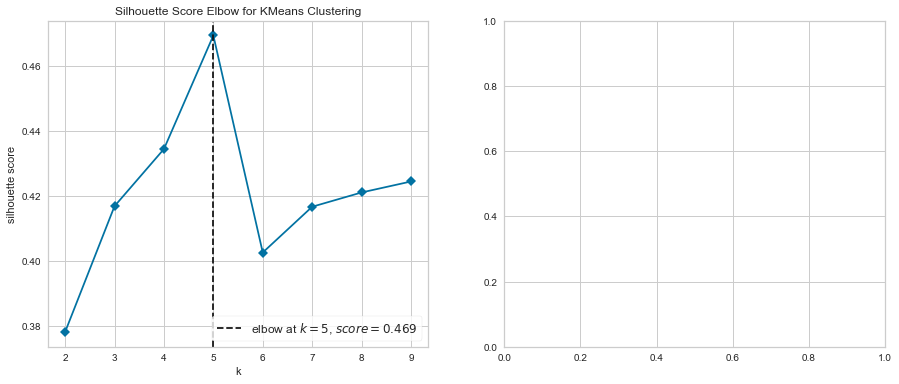

3:2: E225 missing whitespace around operator
5:80: E501 line too long (86 > 79 characters)
5:83: E231 missing whitespace after ','
9:39: E231 missing whitespace after ','


In [21]:
# Instantiate the clustering model and visualizer
metrics = ["silhouette", "calinski_harabasz"]
i=0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
for m in metrics:
    model = KMeans()
    visualizer = KElbowVisualizer(model,
                                  k=(2,10),
                                  metric=m,
                                  ax=axes[i],
                                  timings=False)

    visualizer.fit(rfm_norm)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
    i += 1
plt.show()

#### LOG SCALE

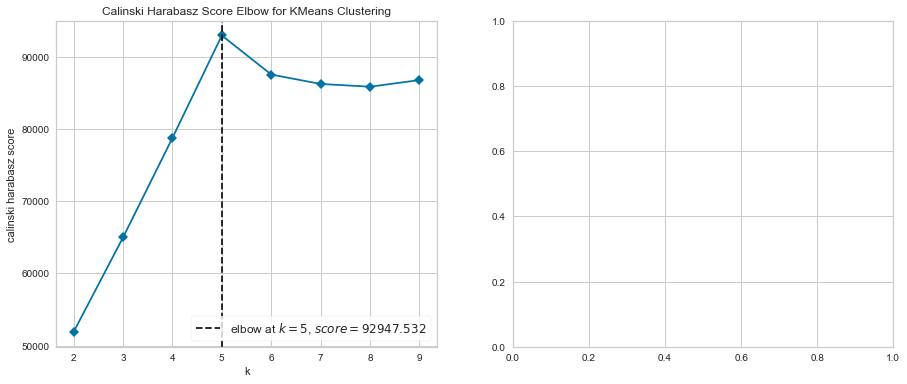

3:2: E225 missing whitespace around operator
5:80: E501 line too long (86 > 79 characters)
5:83: E231 missing whitespace after ','
9:39: E231 missing whitespace after ','


In [22]:
# Instantiate the clustering model and visualizer
metrics = ["calinski_harabasz", "silhouette"]
i=0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
for m in metrics:
    model = KMeans()
    visualizer = KElbowVisualizer(model,
                                  k=(2,10),
                                  metric=m,
                                  ax=axes[i],
                                  timings=False)

    visualizer.fit(rfm_log_scaled)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure
    i += 1
plt.show()

### INTERDISTANCE CLUSTER

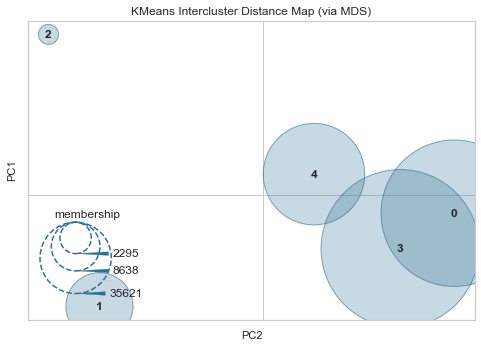

In [23]:
# Intercluster distance Map with best k
distance_visualizer = InterclusterDistance(KMeans(5))
distance_visualizer.fit(rfm_norm)
distance_visualizer.show()
plt.show()

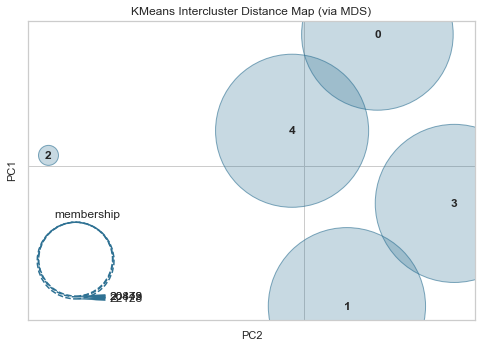

5:11: W291 trailing whitespace


In [24]:
# Intercluster distance Map with best k
distance_visualizer = InterclusterDistance(KMeans(5))
distance_visualizer.fit(rfm_log_scaled)
distance_visualizer.show()
plt.show()                                           

### Selecting the number of clusters with silhouette analysis on KMeans clustering

For n_clusters = 2 The average silhouette_score is : 0.37932508369656476
For n_clusters = 3 The average silhouette_score is : 0.4164588170666796
For n_clusters = 4 The average silhouette_score is : 0.43484403127967447
For n_clusters = 5 The average silhouette_score is : 0.4693132632582653
For n_clusters = 6 The average silhouette_score is : 0.4028806330343638
For n_clusters = 7 The average silhouette_score is : 0.4166447325297144


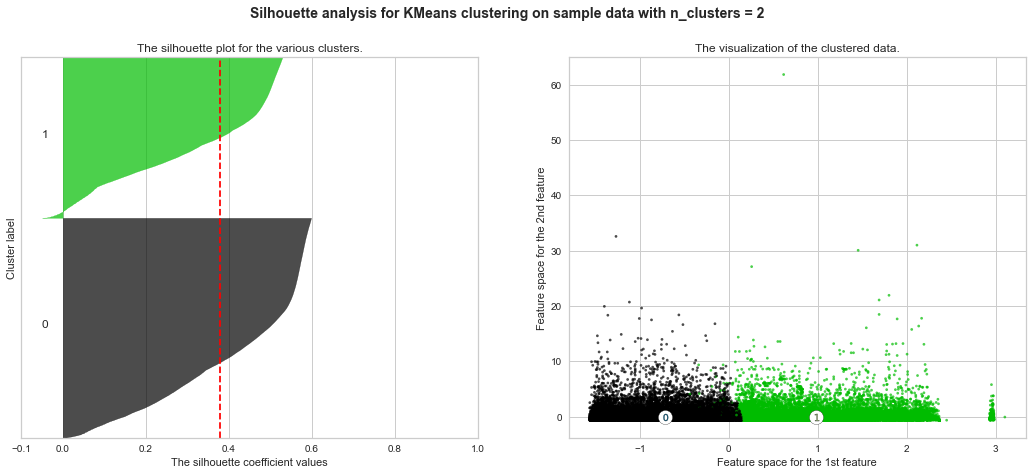

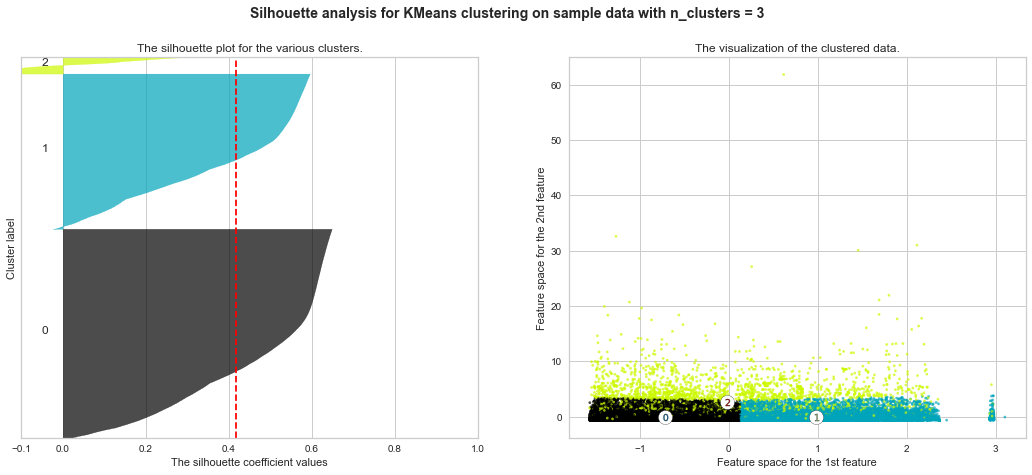

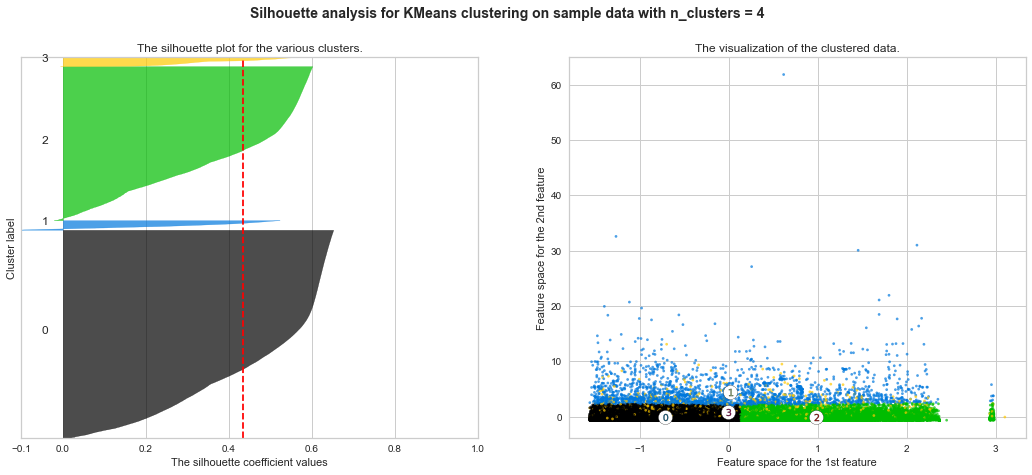

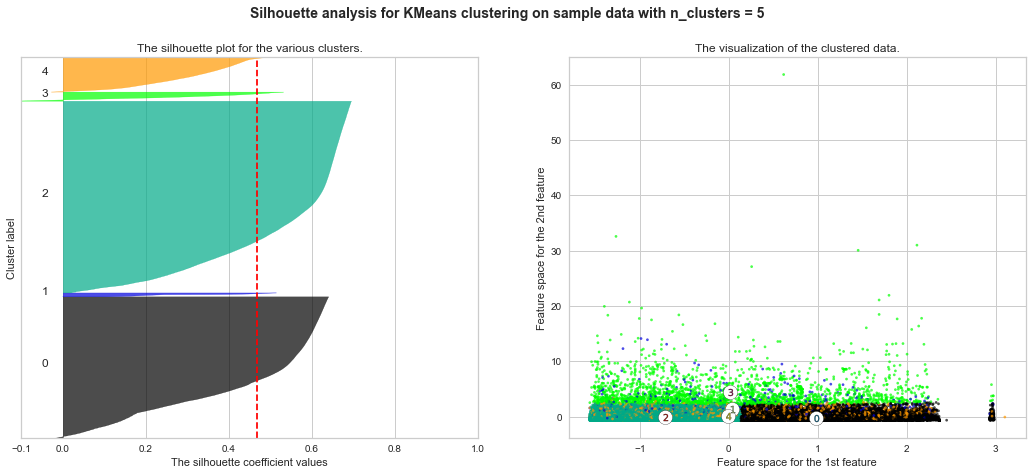

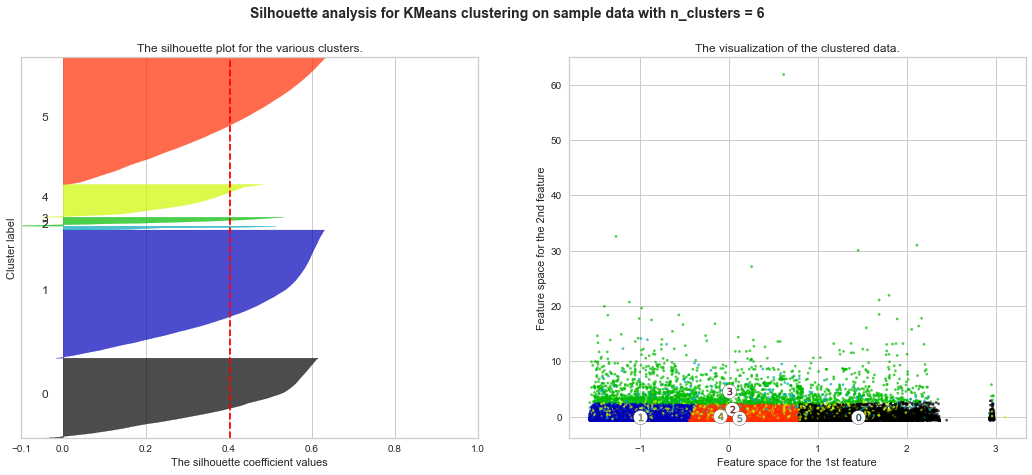

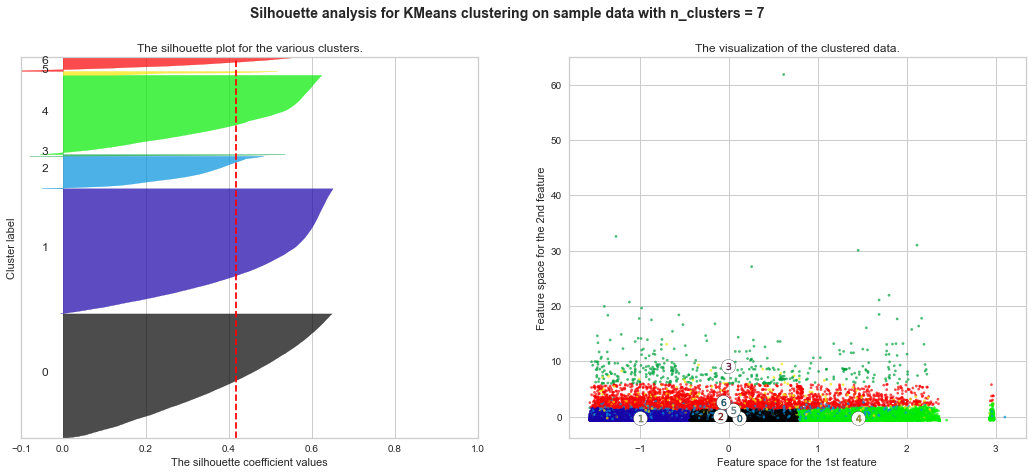

8:1: E303 too many blank lines (7)
10:2: E225 missing whitespace around operator
48:80: E501 line too long (85 > 79 characters)
84:80: E501 line too long (94 > 79 characters)
101:80: E501 line too long (80 > 79 characters)
108:80: E501 line too long (87 > 79 characters)


In [25]:







range_n_clusters = [2, 3, 4, 5, 6, 7]

X=rfm_norm.copy()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### LOG SCALE

For n_clusters = 2 The average silhouette_score is : 0.5371698054930478
For n_clusters = 3 The average silhouette_score is : 0.3768171129413198
For n_clusters = 4 The average silhouette_score is : 0.39704855067705525
For n_clusters = 5 The average silhouette_score is : 0.41865621965774297
For n_clusters = 6 The average silhouette_score is : 0.40557516851976005
For n_clusters = 7 The average silhouette_score is : 0.38142805587461515


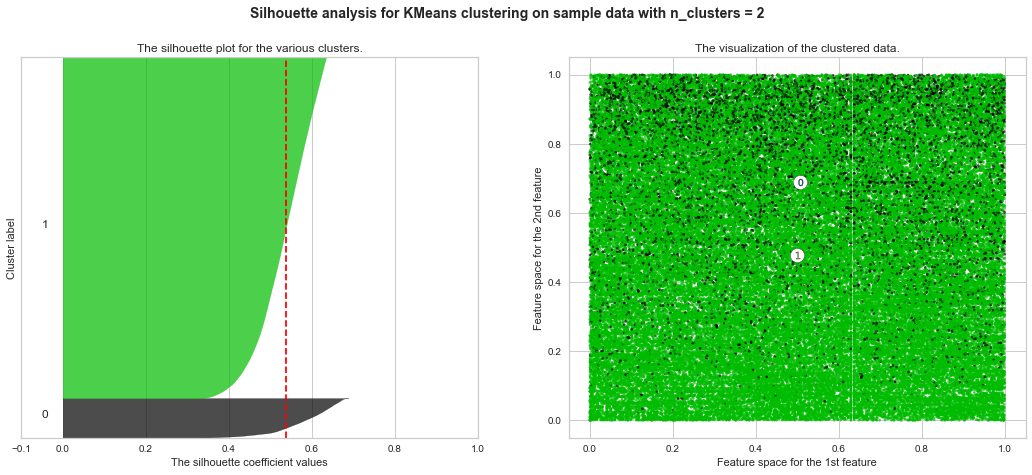

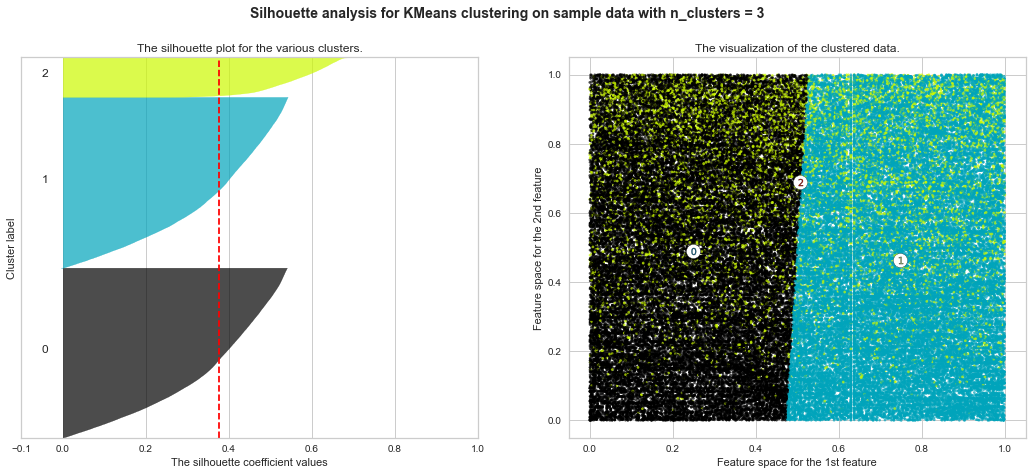

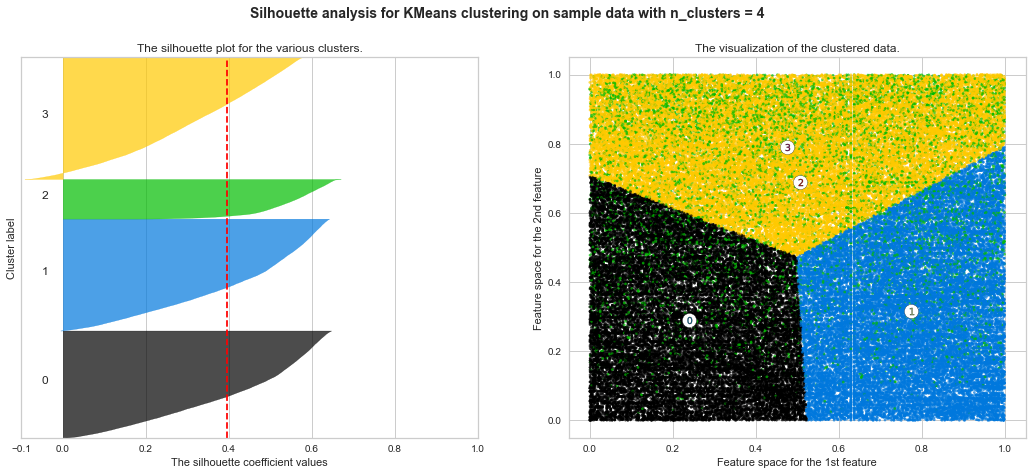

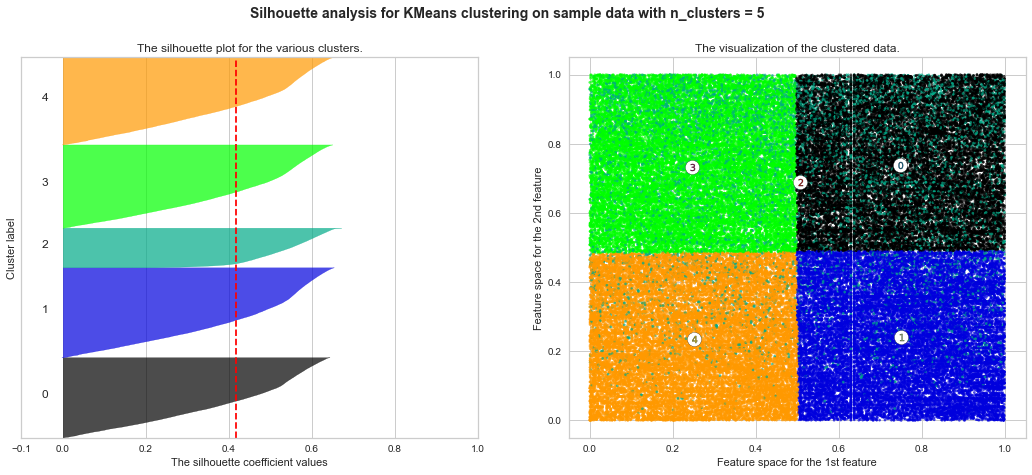

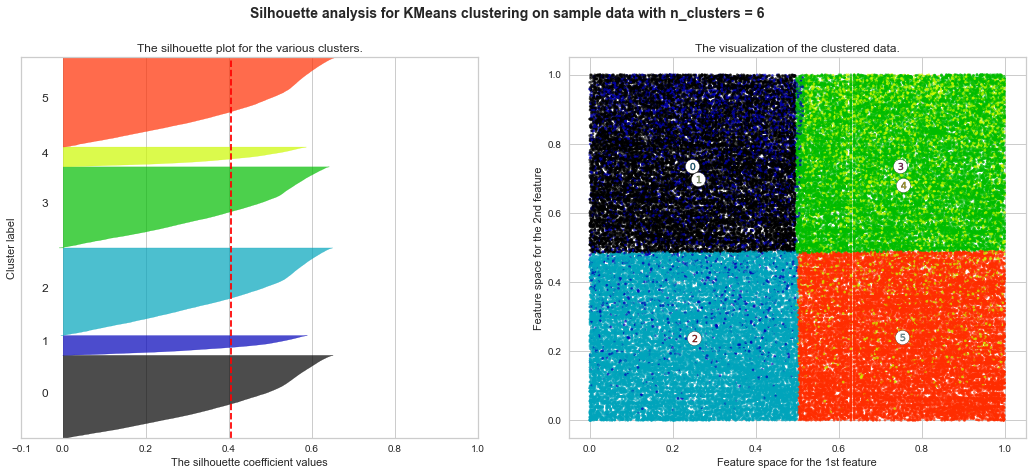

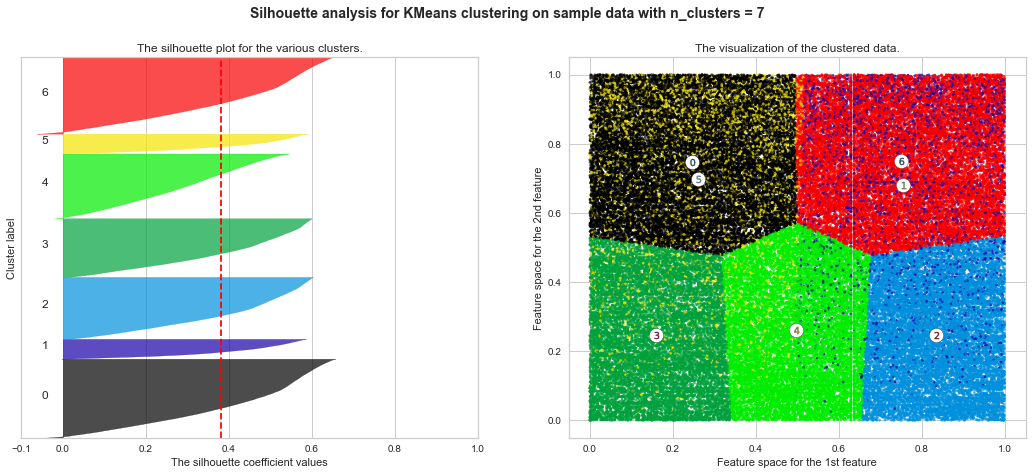

3:2: E225 missing whitespace around operator
41:80: E501 line too long (85 > 79 characters)
77:80: E501 line too long (94 > 79 characters)
94:80: E501 line too long (80 > 79 characters)
101:80: E501 line too long (87 > 79 characters)


In [26]:
range_n_clusters = [2, 3, 4, 5, 6, 7]

X=rfm_log_scaled.copy()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### KMEAN & PCA

We fit the model on the optimum number of clusters

In [27]:
kmeans = cluster.KMeans(n_clusters=5, max_iter=50, n_init=10)
kmeans.fit(rfm_norm)
clusters = kmeans.predict(rfm_norm)

In [28]:
rfm_norm['cluster'] = kmeans.labels_
rfm_norm.head(50)

recency  frequency  monetary  cluster
0   0.314200  -0.208641 -0.268701        2
1   1.112309  -0.425418 -0.268701        2
2   2.015089   0.160884 -0.268701        2
3   0.909511   0.087281 -0.268701        2
4  -0.588579  -0.244045 -0.268701        0
5   1.733788  -0.405311 -0.268701        2
6  -0.392322  -0.507906 -0.268701        0
7   0.098318   0.028839 -0.268701        0
8   0.693629  -0.343800 -0.268701        2
9  -1.445565   5.017142 -0.268701        3
10 -1.105387  -0.059374 -0.268701        0
11  1.910419  -0.464166 -0.268701        2
12 -0.235317   0.502469  5.178769        4
13  0.804841  -0.244228 -0.268701        2
14  1.629118   0.060945 -0.268701        2
15  0.543166  -0.525493  1.547122        1
16  1.674911  -0.247617 -0.268701        2
17  0.340368  -0.095145 -0.268701        2
18 -0.680165  -0.428166 -0.268701        0
19  1.733788  -0.483036 -0.268701        2
20 -0.653998  -0.561905 -0.268701        0
21 -0.084854  -0.274594 -0.268701        0
22 -0.968008  -0.435540 -0.268701        0
23  1.400152  -0.431830 -0.268701        2
24  0.621669  -0.516471 -0.268701        2
25 -0.405406   0.960115 -0.268701        0
26 -0.039061   0.008503 -0.268701        0
27 -0.824086  -0.310044 -0.268701        0
28 -0.359613  -0.453265  1.547122        1
29 -0.045603   0.281662 -0.268701        0
30  1.517906  -0.547524 -0.268701        2
31 -1.053052  -0.128717 -0.268701        0
32  1.014181   0.121128 -0.268701        2
33 -0.398864  -0.505112 -0.268701        0
34 -1.183890  -0.473692 -0.268701        0
35  0.641294  -0.499341 -0.268701        2
36 -0.411948  -0.217389 -0.268701        0
37 -0.104480  -0.488120 -0.268701        0
38 -0.621288  -0.354609 -0.268701        0
39 -0.653998  -0.633676 -0.268701        0
40 -1.412855  -0.537860 -0.268701        0
41 -0.830628  -0.157206 -0.268701        0
42 -0.156815  -0.521051 -0.268701        0
43  2.145926  -0.574501 -0.268701        2
44 -0.856796   3.519396 -0.268701        3
45 -0.137189  -0.414288 -0.268701        0
46 -0.058687   0.447554 -0.268701        0
47  0.909511  -0.550959 -0.268701        2
48 -1.465190   0.383752 -0.268701        0
49 -1.504442  -0.175847 -0.268701        0

### PCA 

In [29]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(rfm_norm)

# Transfor the scaled data to the new PCA space
rfm_reduced = pca.transform(rfm_norm)

# Convert to a data frame
rfm_reduceddf = pd.DataFrame(rfm_reduced, index=rfm_norm.index, columns=['PC1','PC2'])
rfm_reduceddf['cluster'] = clusters
rfm_reduceddf.head()

PC1       PC2  cluster
0  0.803996 -0.545957        2
1  1.215855 -1.047792        2
2  1.914599 -1.096711        2
3  1.239361 -0.634797        2
4 -1.154562  0.042526        0

9:79: E231 missing whitespace after ','
9:80: E501 line too long (86 > 79 characters)


Apply the same PCA transformation to the centroids:

In [30]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

ValueError: X has 3 features, but PCA is expecting 4 features as input.

In [ ]:
display_factorial_planes(rfm_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

To check why the display is fucked up

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig,
            rect=[0, 0, 1, 1],
            elev=28,
            azim=150)

plt.cla()
ax.scatter(rfm_norm['recency'], rfm_norm['frequency'], rfm_norm['monetary'],
           c=rfm_norm['cluster'],
           s=100,
           cmap='spring',
           alpha=0.5,
           edgecolor='darkgrey')

ax.set_xlabel('frequency', fontsize=16)
ax.set_ylabel('recency', fontsize=16)
ax.set_zlabel('monetary', fontsize=16)

plt.show()

### KMEANS-PCA LOG SCALE

In [ ]:
kmeans = cluster.KMeans(n_clusters=4, max_iter=50, n_init=10)
kmeans.fit(rfm_log_scaled)
clusters = kmeans.predict(rfm_log_scaled)

In [ ]:
rfm_log_scaled['cluster'] = kmeans.labels_
rfm_log_scaled.head(5)

In [ ]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(rfm_log_scaled)

# Transfor the scaled data to the new PCA space
rfm_reduced = pca.transform(rfm_log_scaled)

# Convert to a data frame
rfm_reduceddf = pd.DataFrame(rfm_reduced, index=rfm_log_scaled.index, columns=['PC1','PC2'])
rfm_reduceddf['cluster'] = clusters
rfm_reduceddf.head()

In [ ]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

In [ ]:
display_factorial_planes(rfm_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

### Non log

In [ ]:
def kmeans(rfm_norm, clusters_number, df_rfm):
    
    kmeans = cluster.KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_norm)
    
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(n_components=3, perplexity=30.0, random_state=42)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

plt.figure(figsize=(10, 30))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(rfm_norm, 3, df_rfm)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(rfm_norm, 4, df_rfm)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(rfm_norm, 5, df_rfm)
plt.tight_layout()

### Log

In [ ]:
def kmeans(rfm_log_scaled, clusters_number, df_rfm_log):
    
    kmeans = cluster.KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_log_scaled)
    
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new1 = df_rfm_log.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(n_components=3, perplexity=30.0, random_state=42)
    transformed = model.fit_transform(df_new1)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new1

plt.figure(figsize=(10, 30))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(rfm_log_scaled, 3, df_rfm_log)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(rfm_log_scaled, 4, df_rfm_log)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(rfm_log_scaled, 5, df_rfm_log)
plt.tight_layout()

### HDBSCAN

HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection.

In [ ]:
df_rfm_log

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=12,
                            metric='euclidean')
clusterer.fit(rfm_log_scaled[['recency', 'frequency', 'monetary']])
rfm_log_scaled['Cluster'] = pd.Series(clusterer.labels_, index=rfm_log_scaled.index)

rfm_log_scaled.head(5)

In [ ]:
len(rfm_log_scaled['Cluster'].unique())-1

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.colors as mcolors
fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')

for i in range(-1,len(rfm_log_scaled['Cluster'].unique())-1):
    dx.scatter(rfm_log_scaled[rfm_log_scaled.Cluster == i].frequency,
                     rfm_log_scaled[rfm_log_scaled.Cluster == i].recency,
                     rfm_log_scaled[rfm_log_scaled.Cluster == i].monetary,
                     label = 'Cluster ' + str(i),
                     s=10, alpha=1.0)
dx.set_xlabel('Frequency', fontsize=14)
dx.set_ylabel('Recency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)
plt.show()

In [ ]:
pd.Series(clusterer.labels_).value_counts()